# Train an FCN for the classification problem

Architecture:
- Input layer: `50` neurons corresponding to the 50 features in train data
- Hidden layers:
    - First with `35` neurons
    - Next with `20` neurons
- Output layer: `3` neurons corresponding to 3 output classes

Loss function: Weighted cross entropy loss due to class imbalance
Optimizer: SGD

In [1]:
from FCN import Net
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Data
df = pd.read_csv('data/cleaned_train.csv')
feats = []
with open('data/features.txt','r') as f:
    feats = [x[:-1] for x in f.readlines()]
df.shape, df.columns, feats

((74462, 54),
 Index(['id', 'marital_status', 'appln_mode', 'appln_order', 'prog_of_study',
        'morn/eve_attend', 'prev_edu', 'prev_edu_grade', 'nationality',
        'mom_edu', 'dad_edu', 'mom_occup', 'admission_grade', 'was_displaced',
        'edu_spl_need', 'has_student_debt', 'no_fee_dues', 'gender',
        'got_scholarship', 'age_at_start', 'sem1_units_credited',
        'sem1_units_enrolled', 'sem1_units_eval', 'sem1_units_approved',
        'sem1_units_grade', 'sem1_units_no_eval', 'sem2_units_credited',
        'sem2_units_enrolled', 'sem2_units_eval', 'sem2_units_approved',
        'sem2_units_grade', 'sem2_units_no_eval', 'unemployment_rate',
        'inflation', 'gdp', 'Target', 'marital_status_log', 'appln_order_log',
        'prog_of_study_log', 'morn/eve_attend_log', 'prev_edu_log',
        'nationality_log', 'mom_occup_log', 'edu_spl_need_log',
        'has_student_debt_log', 'no_fee_dues_log', 'got_scholarship_log',
        'age_at_start_log', 'sem1_units_credite

In [3]:
val_counts = dict(df['Target'].value_counts())
val_counts

{'Graduate': 36433, 'Dropout': 23325, 'Enrolled': 14704}

Based on this, we assign `0` as `Graduate`, `1` as `Droupout`, `2` as `Enrolled`.

In [4]:
df['Target_enc'] = df['Target'].apply(lambda x: {'Graduate': 0, 'Dropout': 1, 'Enrolled': 2}[x])
df['Target_enc'].unique()

array([0, 1, 2], dtype=int64)

In [5]:
# Data
X,y = df.drop(columns=['Target','Target_enc','id','nationality']).values, df['Target_enc'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X.shape[1]

51

In [6]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [7]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)

In [8]:
# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [9]:
# Instantiate the model, define the optimizer and the loss function
model = Net(X_train.shape[1])
optimizer = optim.AdamW(params=model.parameters(), lr=1e-4)

Class weights

In [10]:
weights = [1.0, val_counts['Dropout']/val_counts['Graduate'], val_counts['Enrolled']/val_counts['Graduate']]
weights

[1.0, 0.640216287431724, 0.4035901517854692]

In [11]:
# Define class weights
class_weights = torch.tensor(weights, dtype=torch.float32)  # Example weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [12]:
# Training the model
num_epochs = 100
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    # Training loop with tqdm
    for inputs, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    
    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    
    # Validation loop with tqdm
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
    
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = correct / len(val_loader.dataset)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

print("Training complete")

Validation Epoch 1/100: 100%|██████████| 466/466 [00:00<00:00, 1303.10it/s]


Epoch 1/100, Train Loss: 0.5646, Validation Loss: 0.3915, Validation Accuracy: 0.7581


Validation Epoch 2/100: 100%|██████████| 466/466 [00:00<00:00, 1780.70it/s]


Epoch 2/100, Train Loss: 0.3696, Validation Loss: 0.3596, Validation Accuracy: 0.7973


Validation Epoch 3/100: 100%|██████████| 466/466 [00:00<00:00, 1652.65it/s]


Epoch 3/100, Train Loss: 0.3514, Validation Loss: 0.3486, Validation Accuracy: 0.8100


Validation Epoch 4/100: 100%|██████████| 466/466 [00:00<00:00, 1677.14it/s]


Epoch 4/100, Train Loss: 0.3429, Validation Loss: 0.3429, Validation Accuracy: 0.8117


Validation Epoch 5/100: 100%|██████████| 466/466 [00:00<00:00, 1864.41it/s]


Epoch 5/100, Train Loss: 0.3376, Validation Loss: 0.3391, Validation Accuracy: 0.8150


Validation Epoch 6/100: 100%|██████████| 466/466 [00:00<00:00, 1319.72it/s]


Epoch 6/100, Train Loss: 0.3341, Validation Loss: 0.3377, Validation Accuracy: 0.8151


Validation Epoch 7/100: 100%|██████████| 466/466 [00:00<00:00, 1839.35it/s]


Epoch 7/100, Train Loss: 0.3318, Validation Loss: 0.3355, Validation Accuracy: 0.8153


Validation Epoch 8/100: 100%|██████████| 466/466 [00:00<00:00, 1613.49it/s]


Epoch 8/100, Train Loss: 0.3304, Validation Loss: 0.3344, Validation Accuracy: 0.8172


Validation Epoch 9/100: 100%|██████████| 466/466 [00:00<00:00, 1488.95it/s]


Epoch 9/100, Train Loss: 0.3287, Validation Loss: 0.3333, Validation Accuracy: 0.8190


Validation Epoch 10/100: 100%|██████████| 466/466 [00:00<00:00, 1862.78it/s]


Epoch 10/100, Train Loss: 0.3278, Validation Loss: 0.3327, Validation Accuracy: 0.8196


Validation Epoch 11/100: 100%|██████████| 466/466 [00:00<00:00, 1793.57it/s]


Epoch 11/100, Train Loss: 0.3266, Validation Loss: 0.3328, Validation Accuracy: 0.8220


Validation Epoch 12/100: 100%|██████████| 466/466 [00:00<00:00, 1715.28it/s]


Epoch 12/100, Train Loss: 0.3259, Validation Loss: 0.3319, Validation Accuracy: 0.8213


Validation Epoch 13/100: 100%|██████████| 466/466 [00:00<00:00, 1853.76it/s]


Epoch 13/100, Train Loss: 0.3251, Validation Loss: 0.3316, Validation Accuracy: 0.8203


Validation Epoch 14/100: 100%|██████████| 466/466 [00:00<00:00, 2129.43it/s]


Epoch 14/100, Train Loss: 0.3244, Validation Loss: 0.3310, Validation Accuracy: 0.8186


Validation Epoch 15/100: 100%|██████████| 466/466 [00:00<00:00, 1797.27it/s]


Epoch 15/100, Train Loss: 0.3237, Validation Loss: 0.3304, Validation Accuracy: 0.8213


Validation Epoch 16/100: 100%|██████████| 466/466 [00:00<00:00, 1969.85it/s]


Epoch 16/100, Train Loss: 0.3231, Validation Loss: 0.3305, Validation Accuracy: 0.8205


Validation Epoch 17/100: 100%|██████████| 466/466 [00:00<00:00, 1858.07it/s]


Epoch 17/100, Train Loss: 0.3226, Validation Loss: 0.3305, Validation Accuracy: 0.8209


Validation Epoch 18/100: 100%|██████████| 466/466 [00:00<00:00, 2002.39it/s]


Epoch 18/100, Train Loss: 0.3221, Validation Loss: 0.3299, Validation Accuracy: 0.8201


Validation Epoch 19/100: 100%|██████████| 466/466 [00:00<00:00, 1997.09it/s]


Epoch 19/100, Train Loss: 0.3216, Validation Loss: 0.3295, Validation Accuracy: 0.8210


Validation Epoch 20/100: 100%|██████████| 466/466 [00:00<00:00, 1978.13it/s]


Epoch 20/100, Train Loss: 0.3213, Validation Loss: 0.3294, Validation Accuracy: 0.8219


Validation Epoch 21/100: 100%|██████████| 466/466 [00:00<00:00, 1391.87it/s]


Epoch 21/100, Train Loss: 0.3211, Validation Loss: 0.3291, Validation Accuracy: 0.8195


Validation Epoch 22/100: 100%|██████████| 466/466 [00:00<00:00, 1637.20it/s]


Epoch 22/100, Train Loss: 0.3206, Validation Loss: 0.3289, Validation Accuracy: 0.8210


Validation Epoch 23/100: 100%|██████████| 466/466 [00:00<00:00, 1845.79it/s]


Epoch 23/100, Train Loss: 0.3203, Validation Loss: 0.3283, Validation Accuracy: 0.8200


Validation Epoch 24/100: 100%|██████████| 466/466 [00:00<00:00, 1713.32it/s]


Epoch 24/100, Train Loss: 0.3198, Validation Loss: 0.3283, Validation Accuracy: 0.8220


Validation Epoch 25/100: 100%|██████████| 466/466 [00:00<00:00, 1847.95it/s]


Epoch 25/100, Train Loss: 0.3195, Validation Loss: 0.3284, Validation Accuracy: 0.8213


Validation Epoch 26/100: 100%|██████████| 466/466 [00:00<00:00, 1851.26it/s]


Epoch 26/100, Train Loss: 0.3191, Validation Loss: 0.3298, Validation Accuracy: 0.8243


Validation Epoch 27/100: 100%|██████████| 466/466 [00:00<00:00, 1998.64it/s]


Epoch 27/100, Train Loss: 0.3191, Validation Loss: 0.3280, Validation Accuracy: 0.8183


Validation Epoch 28/100: 100%|██████████| 466/466 [00:00<00:00, 1657.69it/s]


Epoch 28/100, Train Loss: 0.3188, Validation Loss: 0.3279, Validation Accuracy: 0.8240


Validation Epoch 29/100: 100%|██████████| 466/466 [00:00<00:00, 1668.30it/s]


Epoch 29/100, Train Loss: 0.3182, Validation Loss: 0.3279, Validation Accuracy: 0.8185


Validation Epoch 30/100: 100%|██████████| 466/466 [00:00<00:00, 1857.88it/s]


Epoch 30/100, Train Loss: 0.3181, Validation Loss: 0.3277, Validation Accuracy: 0.8198


Validation Epoch 31/100: 100%|██████████| 466/466 [00:00<00:00, 1729.01it/s]


Epoch 31/100, Train Loss: 0.3175, Validation Loss: 0.3276, Validation Accuracy: 0.8234


Validation Epoch 32/100: 100%|██████████| 466/466 [00:00<00:00, 1570.10it/s]


Epoch 32/100, Train Loss: 0.3176, Validation Loss: 0.3282, Validation Accuracy: 0.8204


Validation Epoch 33/100: 100%|██████████| 466/466 [00:00<00:00, 1388.90it/s]


Epoch 33/100, Train Loss: 0.3174, Validation Loss: 0.3274, Validation Accuracy: 0.8215


Validation Epoch 34/100: 100%|██████████| 466/466 [00:00<00:00, 1466.75it/s]


Epoch 34/100, Train Loss: 0.3169, Validation Loss: 0.3272, Validation Accuracy: 0.8210


Validation Epoch 35/100: 100%|██████████| 466/466 [00:00<00:00, 1413.78it/s]


Epoch 35/100, Train Loss: 0.3165, Validation Loss: 0.3270, Validation Accuracy: 0.8241


Validation Epoch 36/100: 100%|██████████| 466/466 [00:00<00:00, 1862.69it/s]


Epoch 36/100, Train Loss: 0.3165, Validation Loss: 0.3275, Validation Accuracy: 0.8210


Validation Epoch 37/100: 100%|██████████| 466/466 [00:00<00:00, 1948.84it/s]


Epoch 37/100, Train Loss: 0.3166, Validation Loss: 0.3272, Validation Accuracy: 0.8192


Validation Epoch 38/100: 100%|██████████| 466/466 [00:00<00:00, 1530.05it/s]


Epoch 38/100, Train Loss: 0.3161, Validation Loss: 0.3274, Validation Accuracy: 0.8217


Validation Epoch 39/100: 100%|██████████| 466/466 [00:00<00:00, 1801.67it/s]


Epoch 39/100, Train Loss: 0.3160, Validation Loss: 0.3280, Validation Accuracy: 0.8244


Validation Epoch 40/100: 100%|██████████| 466/466 [00:00<00:00, 1490.12it/s]


Epoch 40/100, Train Loss: 0.3156, Validation Loss: 0.3274, Validation Accuracy: 0.8237


Validation Epoch 41/100: 100%|██████████| 466/466 [00:00<00:00, 1667.81it/s]


Epoch 41/100, Train Loss: 0.3158, Validation Loss: 0.3271, Validation Accuracy: 0.8231


Validation Epoch 42/100: 100%|██████████| 466/466 [00:00<00:00, 1854.95it/s]


Epoch 42/100, Train Loss: 0.3154, Validation Loss: 0.3269, Validation Accuracy: 0.8211


Validation Epoch 43/100: 100%|██████████| 466/466 [00:00<00:00, 1870.47it/s]


Epoch 43/100, Train Loss: 0.3151, Validation Loss: 0.3269, Validation Accuracy: 0.8195


Validation Epoch 44/100: 100%|██████████| 466/466 [00:00<00:00, 2000.37it/s]


Epoch 44/100, Train Loss: 0.3147, Validation Loss: 0.3269, Validation Accuracy: 0.8217


Validation Epoch 45/100: 100%|██████████| 466/466 [00:00<00:00, 1631.61it/s]


Epoch 45/100, Train Loss: 0.3151, Validation Loss: 0.3268, Validation Accuracy: 0.8220


Validation Epoch 46/100: 100%|██████████| 466/466 [00:00<00:00, 1756.08it/s]


Epoch 46/100, Train Loss: 0.3149, Validation Loss: 0.3273, Validation Accuracy: 0.8194


Validation Epoch 47/100: 100%|██████████| 466/466 [00:00<00:00, 1656.90it/s]


Epoch 47/100, Train Loss: 0.3147, Validation Loss: 0.3268, Validation Accuracy: 0.8211


Validation Epoch 48/100: 100%|██████████| 466/466 [00:00<00:00, 1766.82it/s]


Epoch 48/100, Train Loss: 0.3148, Validation Loss: 0.3274, Validation Accuracy: 0.8239


Validation Epoch 49/100: 100%|██████████| 466/466 [00:00<00:00, 1727.65it/s]


Epoch 49/100, Train Loss: 0.3142, Validation Loss: 0.3270, Validation Accuracy: 0.8227


Validation Epoch 50/100: 100%|██████████| 466/466 [00:00<00:00, 1874.48it/s]


Epoch 50/100, Train Loss: 0.3141, Validation Loss: 0.3280, Validation Accuracy: 0.8225


Validation Epoch 51/100: 100%|██████████| 466/466 [00:00<00:00, 1845.70it/s]


Epoch 51/100, Train Loss: 0.3143, Validation Loss: 0.3270, Validation Accuracy: 0.8189


Validation Epoch 52/100: 100%|██████████| 466/466 [00:00<00:00, 1829.22it/s]


Epoch 52/100, Train Loss: 0.3141, Validation Loss: 0.3277, Validation Accuracy: 0.8191


Validation Epoch 53/100: 100%|██████████| 466/466 [00:00<00:00, 1844.69it/s]


Epoch 53/100, Train Loss: 0.3137, Validation Loss: 0.3279, Validation Accuracy: 0.8215


Validation Epoch 54/100: 100%|██████████| 466/466 [00:00<00:00, 1840.46it/s]


Epoch 54/100, Train Loss: 0.3138, Validation Loss: 0.3276, Validation Accuracy: 0.8243


Validation Epoch 55/100: 100%|██████████| 466/466 [00:00<00:00, 1859.09it/s]


Epoch 55/100, Train Loss: 0.3136, Validation Loss: 0.3276, Validation Accuracy: 0.8215


Validation Epoch 56/100: 100%|██████████| 466/466 [00:00<00:00, 1746.90it/s]


Epoch 56/100, Train Loss: 0.3138, Validation Loss: 0.3277, Validation Accuracy: 0.8230


Validation Epoch 57/100: 100%|██████████| 466/466 [00:00<00:00, 1868.72it/s]


Epoch 57/100, Train Loss: 0.3132, Validation Loss: 0.3275, Validation Accuracy: 0.8214


Validation Epoch 58/100: 100%|██████████| 466/466 [00:00<00:00, 1313.88it/s]


Epoch 58/100, Train Loss: 0.3132, Validation Loss: 0.3272, Validation Accuracy: 0.8228


Validation Epoch 59/100: 100%|██████████| 466/466 [00:00<00:00, 1770.26it/s]


Epoch 59/100, Train Loss: 0.3129, Validation Loss: 0.3275, Validation Accuracy: 0.8212


Validation Epoch 60/100: 100%|██████████| 466/466 [00:00<00:00, 1389.45it/s]


Epoch 60/100, Train Loss: 0.3127, Validation Loss: 0.3282, Validation Accuracy: 0.8210


Validation Epoch 61/100: 100%|██████████| 466/466 [00:00<00:00, 1639.65it/s]


Epoch 61/100, Train Loss: 0.3129, Validation Loss: 0.3283, Validation Accuracy: 0.8218


Validation Epoch 62/100: 100%|██████████| 466/466 [00:00<00:00, 1679.92it/s]


Epoch 62/100, Train Loss: 0.3125, Validation Loss: 0.3281, Validation Accuracy: 0.8225


Validation Epoch 63/100: 100%|██████████| 466/466 [00:00<00:00, 1761.71it/s]


Epoch 63/100, Train Loss: 0.3125, Validation Loss: 0.3274, Validation Accuracy: 0.8223


Validation Epoch 64/100: 100%|██████████| 466/466 [00:00<00:00, 1849.90it/s]


Epoch 64/100, Train Loss: 0.3126, Validation Loss: 0.3277, Validation Accuracy: 0.8227


Validation Epoch 65/100: 100%|██████████| 466/466 [00:00<00:00, 1746.47it/s]


Epoch 65/100, Train Loss: 0.3125, Validation Loss: 0.3276, Validation Accuracy: 0.8213


Validation Epoch 66/100: 100%|██████████| 466/466 [00:00<00:00, 1773.80it/s]


Epoch 66/100, Train Loss: 0.3126, Validation Loss: 0.3279, Validation Accuracy: 0.8236


Validation Epoch 67/100: 100%|██████████| 466/466 [00:00<00:00, 1792.56it/s]


Epoch 67/100, Train Loss: 0.3121, Validation Loss: 0.3279, Validation Accuracy: 0.8220


Validation Epoch 68/100: 100%|██████████| 466/466 [00:00<00:00, 1567.69it/s]


Epoch 68/100, Train Loss: 0.3120, Validation Loss: 0.3280, Validation Accuracy: 0.8188


Validation Epoch 69/100: 100%|██████████| 466/466 [00:00<00:00, 1761.62it/s]


Epoch 69/100, Train Loss: 0.3121, Validation Loss: 0.3285, Validation Accuracy: 0.8204


Validation Epoch 70/100: 100%|██████████| 466/466 [00:00<00:00, 1741.20it/s]


Epoch 70/100, Train Loss: 0.3118, Validation Loss: 0.3281, Validation Accuracy: 0.8221


Validation Epoch 71/100: 100%|██████████| 466/466 [00:00<00:00, 1762.32it/s]


Epoch 71/100, Train Loss: 0.3118, Validation Loss: 0.3282, Validation Accuracy: 0.8205


Validation Epoch 72/100: 100%|██████████| 466/466 [00:00<00:00, 1720.44it/s]


Epoch 72/100, Train Loss: 0.3116, Validation Loss: 0.3283, Validation Accuracy: 0.8200


Validation Epoch 73/100: 100%|██████████| 466/466 [00:00<00:00, 1830.79it/s]


Epoch 73/100, Train Loss: 0.3115, Validation Loss: 0.3282, Validation Accuracy: 0.8213


Validation Epoch 74/100: 100%|██████████| 466/466 [00:00<00:00, 1761.32it/s]


Epoch 74/100, Train Loss: 0.3115, Validation Loss: 0.3282, Validation Accuracy: 0.8200


Validation Epoch 75/100: 100%|██████████| 466/466 [00:00<00:00, 1628.15it/s]


Epoch 75/100, Train Loss: 0.3112, Validation Loss: 0.3281, Validation Accuracy: 0.8219


Validation Epoch 76/100: 100%|██████████| 466/466 [00:00<00:00, 1641.13it/s]


Epoch 76/100, Train Loss: 0.3113, Validation Loss: 0.3277, Validation Accuracy: 0.8216


Validation Epoch 77/100: 100%|██████████| 466/466 [00:00<00:00, 1552.45it/s]


Epoch 77/100, Train Loss: 0.3113, Validation Loss: 0.3279, Validation Accuracy: 0.8222


Validation Epoch 78/100: 100%|██████████| 466/466 [00:00<00:00, 1637.39it/s]


Epoch 78/100, Train Loss: 0.3108, Validation Loss: 0.3280, Validation Accuracy: 0.8203


Validation Epoch 79/100: 100%|██████████| 466/466 [00:00<00:00, 822.03it/s]


Epoch 79/100, Train Loss: 0.3114, Validation Loss: 0.3291, Validation Accuracy: 0.8202


Validation Epoch 80/100: 100%|██████████| 466/466 [00:00<00:00, 1842.08it/s]


Epoch 80/100, Train Loss: 0.3111, Validation Loss: 0.3281, Validation Accuracy: 0.8218


Validation Epoch 81/100: 100%|██████████| 466/466 [00:00<00:00, 1867.99it/s]


Epoch 81/100, Train Loss: 0.3109, Validation Loss: 0.3282, Validation Accuracy: 0.8229


Validation Epoch 82/100: 100%|██████████| 466/466 [00:00<00:00, 1823.42it/s]


Epoch 82/100, Train Loss: 0.3107, Validation Loss: 0.3290, Validation Accuracy: 0.8215


Validation Epoch 83/100: 100%|██████████| 466/466 [00:00<00:00, 1842.46it/s]


Epoch 83/100, Train Loss: 0.3106, Validation Loss: 0.3289, Validation Accuracy: 0.8229


Validation Epoch 84/100: 100%|██████████| 466/466 [00:00<00:00, 1946.70it/s]


Epoch 84/100, Train Loss: 0.3107, Validation Loss: 0.3281, Validation Accuracy: 0.8217


Validation Epoch 85/100: 100%|██████████| 466/466 [00:00<00:00, 1744.77it/s]


Epoch 85/100, Train Loss: 0.3108, Validation Loss: 0.3275, Validation Accuracy: 0.8215


Validation Epoch 86/100: 100%|██████████| 466/466 [00:00<00:00, 1627.72it/s]


Epoch 86/100, Train Loss: 0.3104, Validation Loss: 0.3281, Validation Accuracy: 0.8235


Validation Epoch 87/100: 100%|██████████| 466/466 [00:00<00:00, 1714.08it/s]


Epoch 87/100, Train Loss: 0.3106, Validation Loss: 0.3277, Validation Accuracy: 0.8218


Validation Epoch 88/100: 100%|██████████| 466/466 [00:00<00:00, 1990.31it/s]


Epoch 88/100, Train Loss: 0.3103, Validation Loss: 0.3282, Validation Accuracy: 0.8215


Validation Epoch 89/100: 100%|██████████| 466/466 [00:00<00:00, 1889.03it/s]


Epoch 89/100, Train Loss: 0.3101, Validation Loss: 0.3280, Validation Accuracy: 0.8237


Validation Epoch 90/100: 100%|██████████| 466/466 [00:00<00:00, 1852.22it/s]


Epoch 90/100, Train Loss: 0.3103, Validation Loss: 0.3287, Validation Accuracy: 0.8228


Validation Epoch 91/100: 100%|██████████| 466/466 [00:00<00:00, 1579.56it/s]


Epoch 91/100, Train Loss: 0.3098, Validation Loss: 0.3278, Validation Accuracy: 0.8229


Validation Epoch 92/100: 100%|██████████| 466/466 [00:00<00:00, 1769.97it/s]


Epoch 92/100, Train Loss: 0.3099, Validation Loss: 0.3287, Validation Accuracy: 0.8200


Validation Epoch 93/100: 100%|██████████| 466/466 [00:00<00:00, 1752.49it/s]


Epoch 93/100, Train Loss: 0.3098, Validation Loss: 0.3286, Validation Accuracy: 0.8239


Validation Epoch 94/100: 100%|██████████| 466/466 [00:00<00:00, 1958.95it/s]


Epoch 94/100, Train Loss: 0.3098, Validation Loss: 0.3280, Validation Accuracy: 0.8227


Validation Epoch 95/100: 100%|██████████| 466/466 [00:00<00:00, 2025.48it/s]


Epoch 95/100, Train Loss: 0.3098, Validation Loss: 0.3282, Validation Accuracy: 0.8235


Validation Epoch 96/100: 100%|██████████| 466/466 [00:00<00:00, 1976.46it/s]


Epoch 96/100, Train Loss: 0.3099, Validation Loss: 0.3280, Validation Accuracy: 0.8211


Validation Epoch 97/100: 100%|██████████| 466/466 [00:00<00:00, 1657.18it/s]


Epoch 97/100, Train Loss: 0.3096, Validation Loss: 0.3280, Validation Accuracy: 0.8233


Validation Epoch 98/100: 100%|██████████| 466/466 [00:00<00:00, 1718.33it/s]


Epoch 98/100, Train Loss: 0.3098, Validation Loss: 0.3286, Validation Accuracy: 0.8233


Validation Epoch 99/100: 100%|██████████| 466/466 [00:00<00:00, 1490.67it/s]


Epoch 99/100, Train Loss: 0.3094, Validation Loss: 0.3286, Validation Accuracy: 0.8241


Validation Epoch 100/100: 100%|██████████| 466/466 [00:00<00:00, 1784.68it/s]

Epoch 100/100, Train Loss: 0.3093, Validation Loss: 0.3275, Validation Accuracy: 0.8236
Training complete


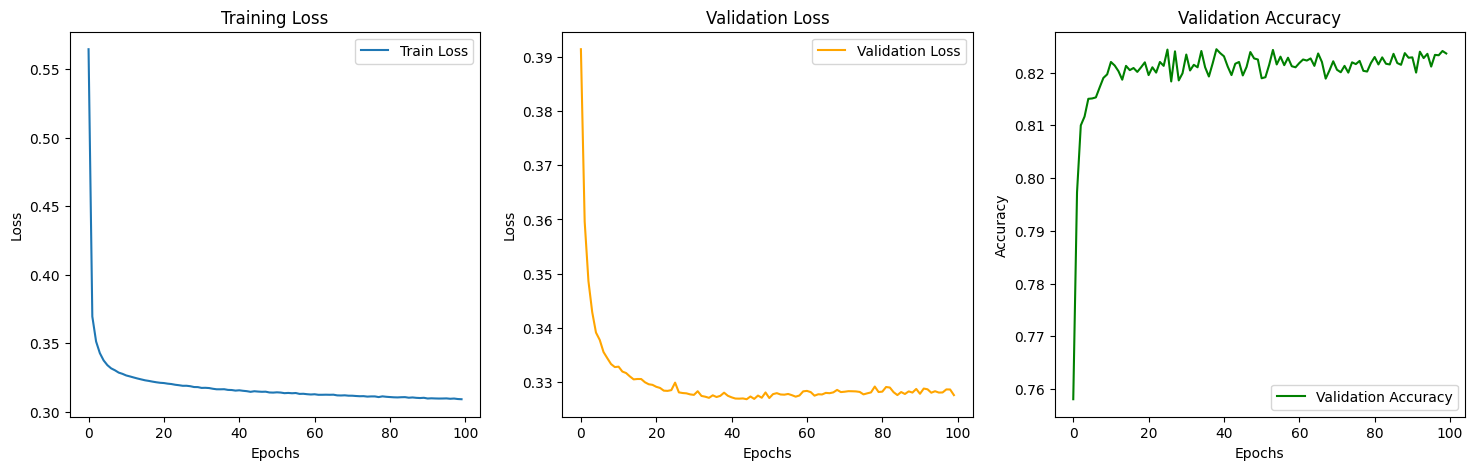

In [13]:
# Plotting the results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Plot train loss
ax1.plot(train_losses, label='Train Loss')
ax1.set_title('Training Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot validation loss
ax2.plot(val_losses, label='Validation Loss', color='orange')
ax2.set_title('Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

# Plot validation accuracy
ax3.plot(val_accuracies, label='Validation Accuracy', color='green')
ax3.set_title('Validation Accuracy')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Accuracy')
ax3.legend()

plt.show()